In [1]:
import xarray as xr
from sea_breeze import sea_breeze_filters, load_model_data, sea_breeze_funcs, utils
from dask.distributed import Client
import os
import pandas as pd
from dask.distributed import Client, progress
import skimage
import warnings

from sea_breeze.sea_breeze_filters import *

In [2]:
client = Client()

2025-01-31 15:08:52,618 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2025-01-31 15:08:52,622 - distributed.utils - INFO - Reload module schedplugin from .py file
2025-01-31 15:08:52,627 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37153 instead
  warnings.warn(


Modifying workers


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0021.gadi.nci.org.au/50224/proxy/37153/status,
Dashboard: /node/gadi-cpu-bdw-0021.gadi.nci.org.au/50224/proxy/37153/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41917,Workers: 7
Dashboard: /node/gadi-cpu-bdw-0021.gadi.nci.org.au/50224/proxy/37153/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44701,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0021.gadi.nci.org.au/50224/proxy/38971/status,Memory: 0 B
Nanny: tcp://127.0.0.1:39161,


In [4]:
#Set up paths to sea_breeze_funcs data output and other inputs
path = "/g/data/gb02/ab4502/"
fc_field_path = path + "sea_breeze_detection/barra_r/Fc_201601010000_201601312300.nc"
hourly_change_path = path+ "sea_breeze_detection/barra_r/F_hourly_201601010000_201601312300.nc"
angle_ds_path = path + "coastline_data/barra_r.nc"

In [38]:
t1 = "2016-01-07 9:00"
t2 = "2016-01-07 9:00"
# t1 = "2016-01-07 08:00"
# t2 = "2016-01-07 08:00"
lat_slice, lon_slice = utils.get_perth_large_bounds()

In [39]:
Fc = xr.open_dataset(
        fc_field_path,chunks="auto"
        ).Fc.sel(lat=lat_slice,lon=lon_slice,time=slice(t1,t2)) 
hourly_change_ds = xr.open_dataset(
        hourly_change_path,chunks="auto"
        ).sel(lat=lat_slice,lon=lon_slice,time=slice(t1,t2))
ta = load_model_data.load_barra_variable(
        "tas",t1,t2,"AUS-11","1hr",lat_slice,lon_slice
        )
uas = load_model_data.load_barra_variable(
        "uas",t1,t2,"AUS-11","1hr",lat_slice,lon_slice
        )
vas = load_model_data.load_barra_variable(
        "vas",t1,t2,"AUS-11","1hr",lat_slice,lon_slice
        )
angle_ds = load_model_data.get_coastline_angle_kernel(
    compute=False,path_to_load=angle_ds_path,lat_slice=lat_slice,lon_slice=lon_slice
    )
uprime,vprime=sea_breeze_funcs.rotate_wind(uas,vas,angle_ds["angle_interp"])
_,lsm = load_model_data.load_barra_static(
        "AUS-11",lon_slice,lat_slice
        )

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


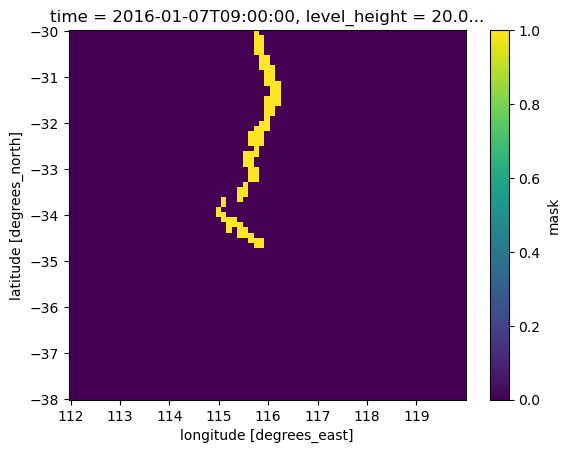

In [40]:
field = Fc

kwargs = {
    "orientation_filter":True,
    "aspect_filter":True,
    "area_filter":True,        
    "land_sea_temperature_filter":True,                    
    "dist_to_coast_filter":False,
    "temperature_change_filter":False,
    "humidity_change_filter":False,
    "wind_change_filter":False,
    "time_filter":False,
    "orientation_tol":45,
    "area_thresh_pixels":10,
    "aspect_thresh":2,
    "land_sea_temperature_diff_thresh":0,
    "max_distance_to_coast_thresh":500,
    "min_distance_to_coast_thresh":0,
    "propagation_speed_filter":True,
    }

ds = sea_breeze_filters.filter_3d(
    field,
    threshold="fixed",
    threshold_value=12.6,
    hourly_change_ds=hourly_change_ds,
    ta=ta,
    vprime=vprime.drop_vars("height"),
    lsm=lsm,
    angle_ds=angle_ds,
    props_df_out_path="/scratch/ng72/ab4502/tmp/props_df",
    save_mask=False,
    **kwargs)

ds.mask.plot()

In [41]:
field = field.chunk({"time":1,"lat":-1,"lon":-1})

ds = sea_breeze_filters.binary_mask(field, 12.6)

ta=ta.chunk({"time":1,"lat":-1,"lon":-1})
ds = xr.merge((ds,ta.rename("ta")),join="exact")   
hourly_change_ds = hourly_change_ds.chunk({"time":1,"lat":-1,"lon":-1})
ds = xr.merge((ds,hourly_change_ds),join="exact").squeeze()

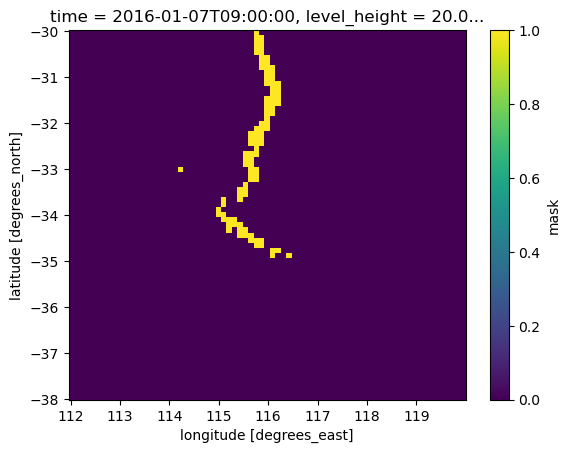

In [42]:
ds.mask.plot()

In [63]:
mask_options = sea_breeze_filters.Mask_Options().set_options(kwargs)

In [64]:
#Get time for data array
#time = pd.to_datetime(mask.time.values).strftime("%Y-%m-%d %H:%M")
time = ds.time.values

#From a binary (mask) array of candidate sea breeze objects, label from 1 to N
labels = skimage.measure.label(ds["mask"])
labels_da = xr.DataArray(labels, dims=ds["mask"].dims, coords=ds["mask"].coords)

#Using skimage, return properties for each candidate object
region_props = skimage.measure.regionprops(labels,spacing=(1,1))

#Get longitudes of image for the purpose of converting to local solar time
lons = ds.lon.values

#Get area of pixels using metpy
dx,dy,pixel_area = utils.metpy_grid_area(ds.lon,ds.lat)
pixel_area = xr.DataArray(pixel_area,coords=ds["mask"].coords,dims=ds["mask"].dims)

In [65]:
vprime.squeeze().groupby(labels_da.rename("label")).mean().to_series().drop(0)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


label
1   -4.791392
2   -3.238459
3   -2.826245
4   -3.134421
dtype: float64

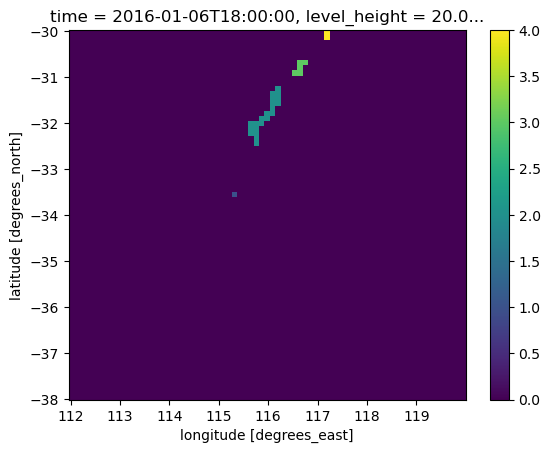

In [66]:
labels_da.plot()

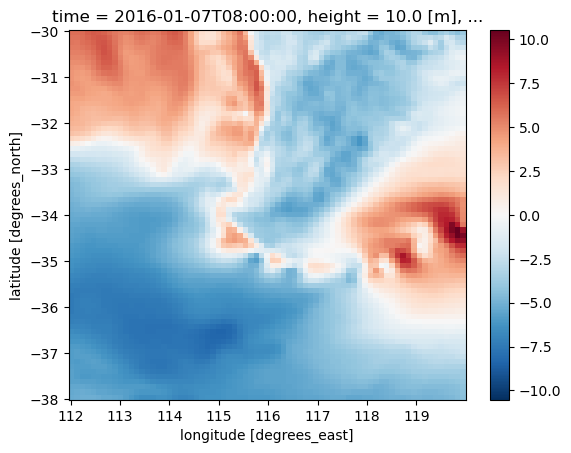

In [49]:
vprime.plot()

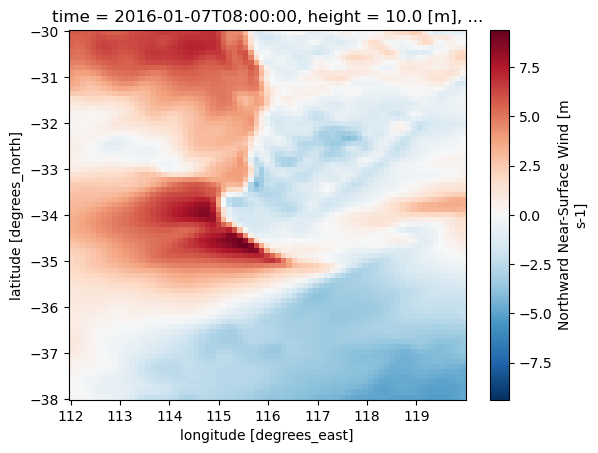

In [53]:
vas.plot()